In [14]:
# PyTorch library imports
import torch  # Main library for tensors and deep learning in PyTorch
import torch.nn as nn  # Neural network module in PyTorch
import torchvision  # Computer vision extension for PyTorch
from torchvision.datasets import ImageFolder  # For loading image data from a directory
import torchvision.transforms as transforms  # For image transformations in PyTorch

# Data handling imports for PyTorch
from torch.utils.data import DataLoader, random_split, Dataset  # For handling datasets in PyTorch

# Standard library imports
import time  # For time-related functions
import copy  # For deep copy operations

# Third-party library imports
import numpy as np  # For numerical operations
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # For model evaluation metrics
from tqdm import tqdm  # For progress bars

In [15]:
# https://pytorch.org/vision/main/models/generated/torchvision.models.vgg11.html
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:
# Check if GPU is available and use it, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [17]:
dataset = ImageFolder(root='../data/art-styles', transform=transform)


In [18]:
from PIL import Image

In [19]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [20]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    model.to(device)
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            dataloader = tqdm(dataloaders[phase], total=len(dataloaders[phase]))
            
            # Iterate over data.
            for inputs, labels, *extra in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                for e in extra:
                    e = e.to(device)    

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    outputs = model(inputs, *extra)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == "test" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "test":
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test Acc: {best_acc:4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history


In [21]:

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels, *extra in tqdm(test_loader, total=len(test_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            for e in extra:
                e = e.to(device)   
            outputs = model(inputs, *extra)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')
    return avg_loss, accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    return accuracy, f1, precision, recall


In [22]:
torchvision.models.VGG11_Weights.__members__

mappingproxy({'IMAGENET1K_V1': VGG11_Weights.IMAGENET1K_V1,
              'DEFAULT': VGG11_Weights.IMAGENET1K_V1})

In [23]:
# Load the pre-trained VGG-11 model and fine-tune on your custom dataset
vgg11_model = torchvision.models.vgg11(
    weights=torchvision.models.VGG11_Weights.IMAGENET1K_V1)


In [24]:
vgg11_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [11]:
# Modify the last layer to match the number of classes in your custom dataset
num_classes = len(set(dataset.classes))
vgg11_model.classifier[6] = nn.Linear(vgg11_model.classifier[6].in_features, num_classes)


In [12]:
vgg11_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [13]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg11_model.parameters(), lr=0.001)


In [14]:
evaluate_model(vgg11_model, test_loader, criterion)

100%|███████████████████████████████████████████| 32/32 [01:37<00:00,  3.03s/it]

Loss: 2.3478, Accuracy: 0.1085, F1-score: 0.0882, Precision: 0.0863, Recall: 0.1080



(2.3478305265307426,
 0.1085,
 0.08816811396209259,
 0.08626981043227755,
 0.10803183787904538)

In [15]:
dataloaders = {"train": train_loader, "test": test_loader}

num_epochs = 5

# Train the model (using the train_model function defined earlier)
trained_vgg_model, test_acc_history = train_model(vgg11_model, dataloaders, criterion, optimizer, device, num_epochs)

Epoch 1/5
----------


100%|█████████████████████████████████████████| 125/125 [18:15<00:00,  8.77s/it]


train Loss: 2.2659 Acc: 0.1315


100%|███████████████████████████████████████████| 32/32 [01:32<00:00,  2.89s/it]


test Loss: 2.1374 Acc: 0.1980

Epoch 2/5
----------


100%|█████████████████████████████████████████| 125/125 [18:23<00:00,  8.83s/it]


train Loss: 2.1078 Acc: 0.2166


100%|███████████████████████████████████████████| 32/32 [01:33<00:00,  2.91s/it]


test Loss: 2.0447 Acc: 0.2580

Epoch 3/5
----------


100%|█████████████████████████████████████████| 125/125 [18:15<00:00,  8.76s/it]


train Loss: 2.0358 Acc: 0.2441


100%|███████████████████████████████████████████| 32/32 [01:32<00:00,  2.88s/it]


test Loss: 1.9909 Acc: 0.2680

Epoch 4/5
----------


100%|█████████████████████████████████████████| 125/125 [18:20<00:00,  8.81s/it]


train Loss: 1.9633 Acc: 0.2737


100%|███████████████████████████████████████████| 32/32 [01:33<00:00,  2.91s/it]


test Loss: 1.9542 Acc: 0.2800

Epoch 5/5
----------


100%|█████████████████████████████████████████| 125/125 [18:19<00:00,  8.80s/it]


train Loss: 1.9132 Acc: 0.2985


100%|███████████████████████████████████████████| 32/32 [01:32<00:00,  2.89s/it]

test Loss: 1.8837 Acc: 0.3310

Training complete in 99m 18s
Best test Acc: 0.331000


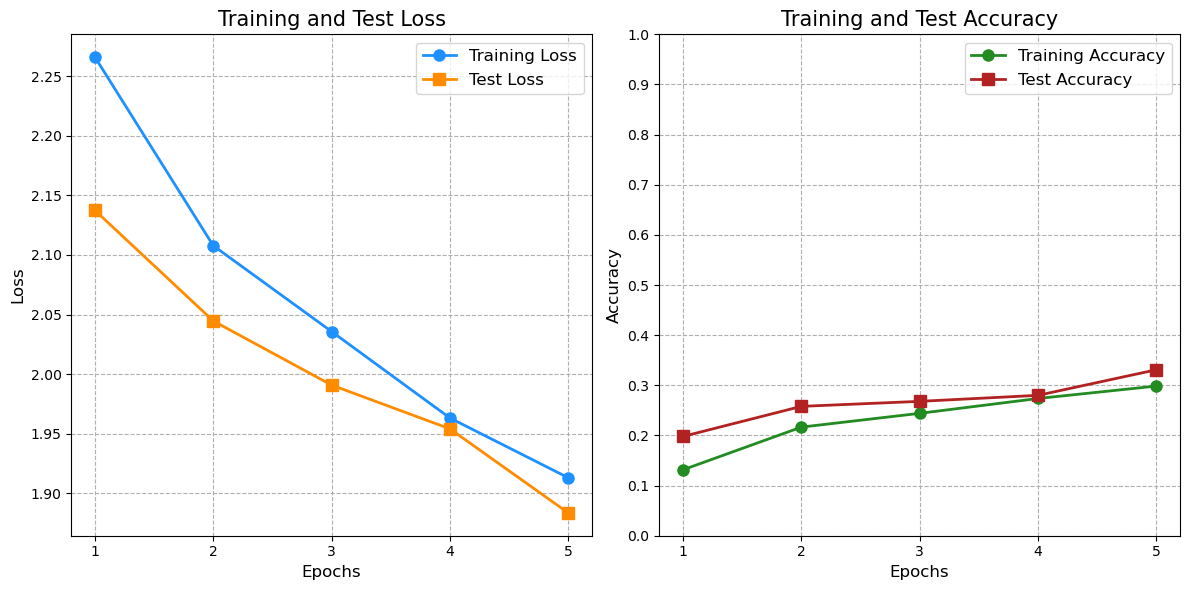

In [41]:
import matplotlib.pyplot as plt

# Loss values for each epoch
train_loss = [2.2659, 2.1078, 2.0358, 1.9633, 1.9132]
test_loss = [2.1374, 2.0447, 1.9909, 1.9542, 1.8837]

# Accuracy values for each epoch
train_acc = [0.1315, 0.2166, 0.2441, 0.2737, 0.2985]
test_acc = [0.1980, 0.2580, 0.2680, 0.2800, 0.3310]

# Number of epochs
epochs = range(1, 6)

plt.figure(figsize=(12, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', lw=2, markersize=8, label='Training Loss', color='dodgerblue')
plt.plot(epochs, test_loss, 's-', lw=2, markersize=8, label='Test Loss', color='darkorange')
plt.title('Training and Test Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.legend(fontsize=12)

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', lw=2, markersize=8, label='Training Accuracy', color='forestgreen')
plt.plot(epochs, test_acc, 's-', lw=2, markersize=8, label='Test Accuracy', color='firebrick')
plt.title('Training and Test Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.yticks([i * 0.1 for i in range(11)]) # Y-axis in increments of 0.1
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


The training and testing loss, as well as training and testing accuracy, over five epochs. The plot shows that both training and testing loss are decreasing together, and training and testing accuracy are increasing together.

Here's why this might be happening, especially considering that we are using a larger pre-trained VGG model:

1. Appropriate Model Complexity: A larger pre-trained VGG model is likely to have a more expressive feature extraction capacity. If the problem aligns well with the features that VGG is capable of capturing, the model may be able to learn more rapidly and effectively. This might result in both training and testing loss moving together as the model identifies relevant patterns in both datasets.

2. Regularization: The model is regularized appropriately, either through techniques like dropout, weight decay, or simply through careful hyperparameter tuning, it may generalize better to the unseen test data. This can result in the training and testing loss (and accuracy) following a similar trend.

3. Pre-training: Since VGG is a pre-trained model, it already has learned valuable features from its training on a large dataset like ImageNet. This can make the model more robust and capable of generalizing from the training data to the test data in the specific problem, leading to the observed behavior.


In [16]:
evaluate_model(trained_vgg_model, test_loader, criterion)

100%|███████████████████████████████████████████| 32/32 [01:32<00:00,  2.89s/it]

Loss: 1.8897, Accuracy: 0.3310, F1-score: 0.3248, Precision: 0.3591, Recall: 0.3294



(1.8896917812526226,
 0.331,
 0.3247992930099854,
 0.3591019502652492,
 0.3294200596279827)

In [44]:
import torch

# Save the trained model
torch.save(trained_vgg_model.state_dict(), "../data/trained_vgg_model.pt")


## Try with a bigger VGG 16

In [17]:
# Load the pre-trained VGG-11 model and fine-tune on your custom dataset
vgg16_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

# Modify the last layer to match the number of classes in your custom dataset
num_classes = len(set(dataset.classes))
vgg16_model.classifier[-1] = nn.Linear(vgg16_model.classifier[-1].in_features, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=0.001)

evaluate_model(vgg16_model, test_loader, criterion)

100%|███████████████████████████████████████████| 32/32 [02:43<00:00,  5.11s/it]

Loss: 2.3784, Accuracy: 0.0690, F1-score: 0.0395, Precision: 0.0439, Recall: 0.0679



(2.3783892393112183,
 0.069,
 0.03949636325648687,
 0.043851258824304844,
 0.06785678990095537)

In [18]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
dataloaders = {"train": train_loader, "test": test_loader}

num_epochs = 5

# Train the model (using the train_model function defined earlier)
trained_vgg16_model, test_acc_history = train_model(vgg16_model, dataloaders, criterion, optimizer, device, num_epochs)


Epoch 1/5
----------


100%|█████████████████████████████████████████| 125/125 [39:35<00:00, 19.01s/it]


train Loss: 2.3226 Acc: 0.1062


100%|███████████████████████████████████████████| 32/32 [02:43<00:00,  5.10s/it]


test Loss: 2.2488 Acc: 0.1500

Epoch 2/5
----------


100%|█████████████████████████████████████████| 125/125 [40:01<00:00, 19.21s/it]


train Loss: 2.2746 Acc: 0.1411


100%|███████████████████████████████████████████| 32/32 [02:42<00:00,  5.07s/it]


test Loss: 2.2292 Acc: 0.1405

Epoch 3/5
----------


100%|█████████████████████████████████████████| 125/125 [40:08<00:00, 19.27s/it]


train Loss: 2.2074 Acc: 0.1709


100%|███████████████████████████████████████████| 32/32 [02:41<00:00,  5.06s/it]


test Loss: 2.1405 Acc: 0.1960

Epoch 4/5
----------


100%|█████████████████████████████████████████| 125/125 [40:09<00:00, 19.28s/it]


train Loss: 2.1874 Acc: 0.1833


100%|███████████████████████████████████████████| 32/32 [02:41<00:00,  5.06s/it]


test Loss: 2.1697 Acc: 0.1870

Epoch 5/5
----------


100%|█████████████████████████████████████████| 125/125 [40:07<00:00, 19.26s/it]


train Loss: 2.1504 Acc: 0.1941


100%|███████████████████████████████████████████| 32/32 [02:43<00:00,  5.10s/it]

test Loss: 2.0759 Acc: 0.2375

Training complete in 213m 36s
Best test Acc: 0.237500


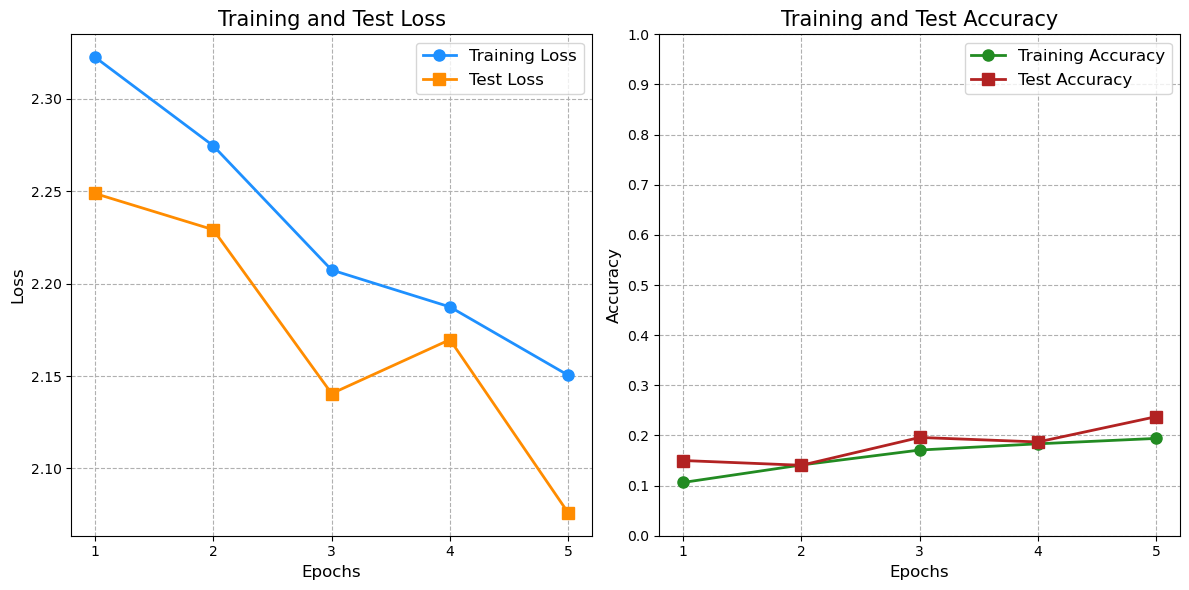

In [40]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_loss = [2.3226, 2.2746, 2.2074, 2.1874, 2.1504]
train_acc = [0.1062, 0.1411, 0.1709, 0.1833, 0.1941]
test_loss = [2.2488, 2.2292, 2.1405, 2.1697, 2.0759]
test_acc = [0.1500, 0.1405, 0.1960, 0.1870, 0.2375]

# Number of epochs
epochs = range(1, 6)

plt.figure(figsize=(12, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', lw=2, markersize=8, label='Training Loss', color='dodgerblue')
plt.plot(epochs, test_loss, 's-', lw=2, markersize=8, label='Test Loss', color='darkorange')
plt.title('Training and Test Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.legend(fontsize=12)

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', lw=2, markersize=8, label='Training Accuracy', color='forestgreen')
plt.plot(epochs, test_acc, 's-', lw=2, markersize=8, label='Test Accuracy', color='firebrick')
plt.title('Training and Test Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.yticks([i * 0.1 for i in range(11)]) # Y-axis in increments of 0.1
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [20]:
evaluate_model(trained_vgg16_model, test_loader, criterion)

100%|███████████████████████████████████████████| 32/32 [02:45<00:00,  5.16s/it]

Loss: 2.0784, Accuracy: 0.2375, F1-score: 0.1932, Precision: 0.2944, Recall: 0.2358



(2.0783711187541485,
 0.2375,
 0.19315301562881834,
 0.29440831790261274,
 0.23584127324962884)

In [21]:
import torch

# Save the trained model
torch.save(trained_vgg16_model.state_dict(), "../data/trained_vgg_16_model.pt")


The fact that a larger VGG model (like VGG-16) might perform worse than a smaller one (like VGG-11) on the same data may seem counterintuitive, as larger models generally have more capacity to learn complex features. However, there are several reasons why this might happen:

1. Overfitting: VGG-16 has more layers and parameters compared to VGG-11, which increases its capacity to fit complex patterns. While this can be a strength, it might also lead to overfitting, especially if the dataset is relatively small or lacks diversity. Overfitting would cause the model to perform well on training data but poorly on unseen test data.

2. Not Enough Training: Larger models typically require more data and more training time to converge. If the VGG-16 model is not trained for enough epochs or with enough data, it might not reach a good optimum, resulting in subpar performance compared to the smaller VGG-11.

3. Hyperparameter Tuning: Different models might require different hyperparameter settings, such as learning rate, batch size, or weight decay. If the hyperparameters are optimized for VGG-11 but applied without modification to VGG-16, the latter might not perform at its best.

4. Dataset Complexity: If the dataset's underlying patterns are relatively simple, a more complex model like VGG-16 may not provide any advantage and might even perform worse. Simpler models like VGG-11 can sometimes generalize better when the underlying complexity of the data is low.

# BERT

In [28]:
import pandas as pd
from nlp import Dataset
import numpy as np

In [29]:
# Step 1: Load and preprocess the data
csv_path = '../data/disaster.csv'
tweets = pd.read_csv(csv_path)


In [30]:
tweets.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [31]:
# the trainer is expecting a 'label' (see the forward method in the docs)
tweets['label'] = tweets['target']
del tweets['target']

tweet_dataset = Dataset.from_pandas(tweets)

In [32]:
tweet_dataset

Dataset(features: {'id': Value(dtype='int64', id=None), 'keyword': Value(dtype='string', id=None), 'location': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}, num_rows: 7613)

In [33]:
BERT_MODEL = 'bert-base-uncased'  # uncased will lowercase everything and remove accents
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

In [34]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return bert_tokenizer(examples["text"], truncation=True)

tweet_dataset = tweet_dataset.map(preprocess_function, batched=True)


  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
tweet_dataset['train']

Dataset(features: {'id': Value(dtype='int64', id=None), 'keyword': Value(dtype='string', id=None), 'location': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 6090)

In [38]:
tweet_dataset['test']

Dataset(features: {'id': Value(dtype='int64', id=None), 'keyword': Value(dtype='string', id=None), 'location': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 1523)

In [39]:
tweet_dataset['train'][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'id': 5371,
 'input_ids': [101,
  1005,
  2019,
  2324,
  1011,
  12819,
  2234,
  2247,
  1998,
  4930,
  1996,
  2543,
  4744,
  9419,
  2009,
  2105,
  8380,
  5445,
  1998,
  4786,
  2009,
  2000,
  4897,
  2058,
  1005,
  8299,
  1024,
  1013,
  1013,
  1056,
  1012,
  2522,
  1013,
  2463,
  14376,
  25619,
  28061,
  2080,
  102],
 'keyword': 'fire%20truck',
 'label': 1,
 'location': 'Here & There',
 'text': "'An 18-wheeler came along and struck the fire truck spinning it around 180 degrees and causing it to roll over' http://t.co/kmPfhGlhoo",
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [9]:
from transformers import DataCollatorWithPadding

# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [11]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

sequence_classification_model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2,
)

sequence_classification_model.config.id2label = {0: 'NOT DISASTER', 1: 'DISASTER'}

sequence_classification_model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
sequence_classification_model.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [88]:
# Define the compute_metrics function to calculate accuracy, f1, precision, and recall
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = np.mean(preds == labels)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall}


In [89]:
batch_size = 8
epochs = 5

training_args = TrainingArguments(
    output_dir='./clf/results',
    logging_dir='./clf/logs',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    eval_steps=1,
    save_strategy='epoch',
    report_to="wandb",  # enable logging to W&B
#     use_mps_device=True # might be neccesary on a mac
)

# Define the trainer: 

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=tweet_dataset['train'],
    eval_dataset=tweet_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [90]:
trainer.evaluate()

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6799960732460022,
 'eval_accuracy': 0.5449770190413658,
 'eval_precision': 0.2969999512832131,
 'eval_recall': 0.5449770190413658,
 'eval_runtime': 8.9948,
 'eval_samples_per_second': 169.32,
 'eval_steps_per_second': 21.234}

In [91]:
trainer.train()

/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.039000,0.473227,0.813526,0.815029,0.813526
2,0.019900,0.601717,0.824032,0.834675,0.824032
3,0.013300,0.674782,0.816809,0.818575,0.816809
4,2.005600,0.902381,0.810900,0.814008,0.810900
5,0.001100,1.079001,0.806960,0.806711,0.806960


In [92]:
trainer.evaluate()  # sanity check

{'eval_loss': 0.47322705388069153,
 'eval_accuracy': 0.8135259356533159,
 'eval_precision': 0.8150288673518512,
 'eval_recall': 0.8135259356533159,
 'eval_runtime': 8.3998,
 'eval_samples_per_second': 181.313,
 'eval_steps_per_second': 22.739,
 'epoch': 5.0}

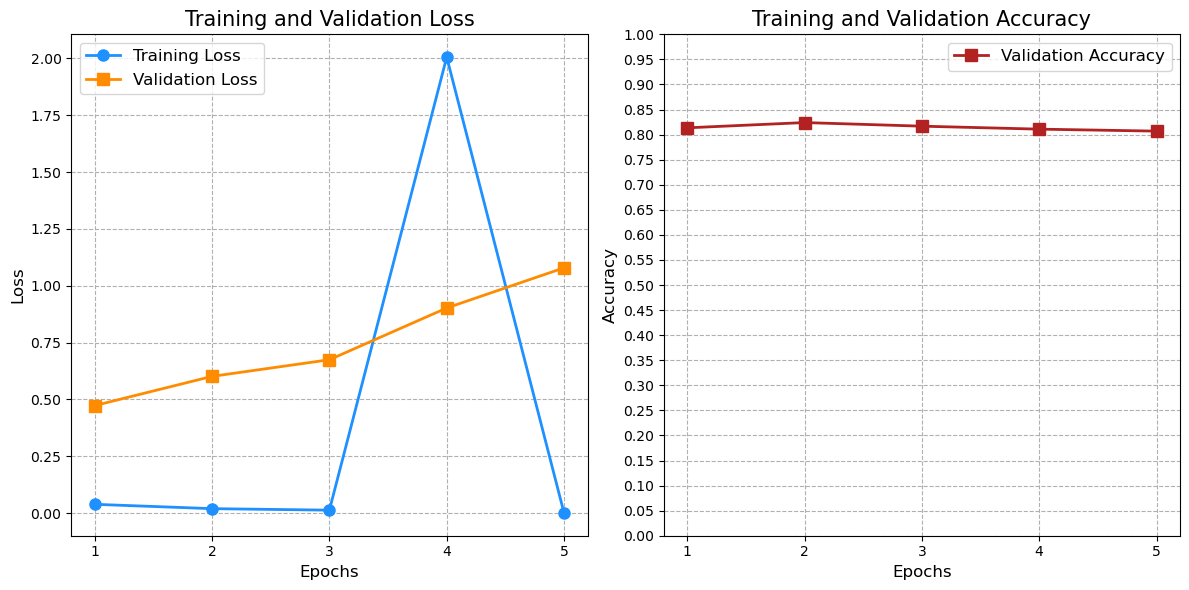

In [97]:
import matplotlib.pyplot as plt

# Loss and accuracy values for each epoch
train_loss = [0.039000, 0.019900, 0.013300, 2.005600, 0.001100]
val_loss = [0.473227, 0.601717, 0.674782, 0.902381, 1.079001]
val_acc = [0.813526, 0.824032, 0.816809, 0.810900, 0.806960]

# Number of epochs
epochs = range(1, 6)

plt.figure(figsize=(12, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', lw=2, markersize=8, label='Training Loss', color='dodgerblue')
plt.plot(epochs, val_loss, 's-', lw=2, markersize=8, label='Validation Loss', color='darkorange')
plt.title('Training and Validation Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.legend(fontsize=12)

# Plot for accuracy
plt.subplot(1, 2, 2)
# plt.plot(epochs, train_acc, 'o-', lw=2, markersize=8, label='Training Accuracy', color='forestgreen')
plt.plot(epochs, val_acc, 's-', lw=2, markersize=8, label='Validation Accuracy', color='firebrick')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.yticks([i * 0.05 for i in range(21)]) # Y-axis in increments of 0.05
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


Woahhhhh that's interesting. Here's an analysis of what we're observing:

1. Training Loss Decline: We see a drastic drop in the training loss during the first few epochs, which is typically indicative of the model learning well. However, there is an unexpected spike at epoch 4 before it drops again. This could be due to various factors such as an outlier in the training data, learning rate issues, or other stochastic behaviors related to the training process.

2. Validation Loss Increase: On the other hand, the validation loss is increasing after the first epoch. This is typically indicative of overfitting, where the model is becoming too specialized to the training data and performs poorly on unseen data. The increasing complexity and fit to the training data may not generalize well to the validation data, causing this discrepancy between training and validation loss.

3. Validation Accuracy Plateau: The validation accuracy shows a slight increase initially but then starts to decline, indicating that the model is not improving on the validation set. This behavior, coupled with the increasing validation loss, is a strong sign of overfitting.

Potential Remedies:

1. We want to consider early stopping, where the training is halted once the validation performance starts to degrade, to prevent overfitting.
2. Regularization techniques like dropout, L2 regularization, etc., might also help in reducing overfitting.
3. Adjusting the learning rate or using a learning rate scheduling policy could resolve the odd spike in the training loss.
4. Analyzing the training data for inconsistencies or issues that might cause erratic training behavior may also be beneficial.
5. The combination of these metrics and trends paints a picture of a model that is learning the training data quite well but struggling to generalize to unseen data, a classic sign of overfitting. Adjusting the training process with some of the strategies above might help in achieving a more balanced and robust model.






# Tips going forward

Choosing the right model, parameters, and regularization techniques is a crucial step in developing a successful machine learning pipeline. The optimal architecture depends on the specific nature of the task and the data. Here are some general tips:

1. Understand the Data: Begin by exploring and understanding the data and the underlying problem. Simpler datasets might not require highly complex models, while intricate patterns might demand more layers or features.
2. Grid or Random Search: Utilize grid search or random search to systematically explore different combinations of hyperparameters. Tools like Scikit-learn's GridSearchCV can be particularly helpful.
3. Transfer Learning: If applicable, consider using pre-trained models and fine-tuning them to your specific task. This can leverage knowledge learned from related tasks and often reduce training time.
4. Monitor Learning Curves: Plotting the training and validation loss and accuracy during training can provide insights into whether the model is underfitting, overfitting, or converging optimally.
5. Consider Computational Constraints: Be mindful of the available computational resources, as large models require more memory and time to train. This might influence the choice of architecture.
6. Iterate and Experiment: Building a model is often an iterative process. Experiment with different architectures, optimization techniques, and data augmentations to find the combination that works best for the task.
7. Start Simple: It's often beneficial to start with a simpler model and progressively add complexity if needed. This can help in understanding how the complexity of the model affects performance.

Remember, there is often no one-size-fits-all solution in machine learning. The process of finding the optimal architecture requires thoughtful experimentation, patience, and a solid understanding of both the data and the algorithms being used.